# PyClust Benchmarking

- [Introduction](#Introduction)
- [Benchmarks Against Other Modules](#Benchmatks-Against-Other-Modules)
    - [Expirimentation Setup](##Experimentation-Setup)
    - [ClusterFeatures](##ClusterFeatures)
    - [ClusterCrit](##ClusterCrit)

# Introduction 

In this notebook, we benchmark PyClust's computation of internal Cluster Validity Indices (CVIs) and compare it against other popular modules.

PyClust, compared to the other modules that are selected for comparison, has the following advantages:

1. PyClust supports the computation of 46 different internal CVIs, compared to [ClustersFeatures](https://github.com/Simon-Bertrand/Clusters-Features) (Python) which supports 40, [ClusterCrit](https://cran.r-project.org/web/packages/clusterCrit/index.html) (R) which supports 42 and [Scikit-Learn](https://scikit-learn.org/stable/), the most commonly used machine learning Python library, which supports only 3.

2. PyClust is optimized to compute fast multiple internal CVIs. In contrast to  ClustersFeatures, ClusterCrit and Scikit-Learn, PyClust integrates a tracking mechanism of intermiediate computations to CVIs in order to reuse their results wherever applicable leading to very fast execution times, especially when many CVIs are needed.

For example, lets see the definition of 18 internal CVIs named Generalized Dunn Indexes (GDIs). We define the following meetrics:
$$\Delta_1(C_k) = \max_{x,y\in C_k} d(x, y)$$
$$\Delta_2(C_k)= \frac{1}{|C_k|\cdot |C_k - 1|} \sum_{x,y\in C_k} d(x, y)$$
$$\Delta_3(C_k) = \frac{2}{|C_k|} \sum_{x\in C_k} d(x, \mu_k)$$

and

$$\delta_1(C_i, C_j) = \min_{x\in C_i, y\in C_j} d(x, y)$$
$$\delta_2(C_i, C_j) = \max_{x\in C_i, y\in C_j} d(x, y)$$
$$\delta_3(C_i, C_j) = \frac{1}{|C_i| \cdot |C_j|} \sum_{x\in C_i, y\in C_j} d(x, y)$$
$$\delta_4(C_i, C_j) = d(\mu_i, \mu_j)$$
$$\delta_5(C_i, C_j) = \frac{1}{|C_i|+|C_j|} \left ( \sum_{x\in C_i} d(x, \mu_i) + \sum_{y\in C_j} d(y, \mu_j) \right )$$
$$\delta_6(C_i, C_j) = \max \left \{ \sup_{x\in C_i} \inf_{y\in C_j} d(x, y), \sup_{y\in C_j} \inf_{x\in C_i} d(x, y) \right \}$$

where 
$$C_k$$
is cluster k and,
$$\mu_i$$
is the centroid of cluster k.

Those formulas produce 18 internal CVIs determined as

$$GDI(i, j) = \frac{\min_{k\neq k'} \delta_i(C_k, C_{k'})}{\max_k \Delta_j(C_k)}$$

PyClust not only supports the computation of all GDIs (ClusterCrit does not support GDI(6,1), GDI(6,2), GDI(6,3)), but in contrast to ClustersFeatures and ClusterCrit, if one want to compute all of them, the corresponding library/package will compute 
$$\min_{k\neq k'} \delta_i \text{ and }m \max_k\Delta_j$$
separately, while PyClust will compute them once and use them to compute all GDI indexes.

![Alt text](cvis.png)

# Benchmarks Against Other Modules

In this section we compare PyClust against 3 other popular modules for CVI extraction (ClusterFeatures, ClusterCrit, ScikitLearn). That is we generate synthetic data (gaussian blobs) of sizes [100,500,1000,2000] and then we calculate a set of CVI from both PyClust and the target module. Because these libraries contain the implementation of a subset of the CVIs included in PyClust. Each time we match this set for the calculation of CVI from PyClust to ensure fair results. 

## Experimentation Setup 

First we will generate set of 75 datasets that vary on sample and feature size. Additionally we generate each for a different of 5 random states to ensure our results are not affected by the specifics of the dataset instances and any other processes running on the machine used for experimentation. 

In [ ]:
import os 
import json
from sklearn.datasets import make_blobs
import pandas as pd 

In [ ]:
# Keep paths for later usage 
cwd = os.getcwd()
parent_path = os.path.dirname(cwd)
print(parent) 
data_path = os.path.join(parent, "data")
print(data)

d:\PyClust-Eval\benchmarks
d:\PyClust-Eval\benchmarks\data


In [ ]:
# Dataset Generation specifics (Sample size/No Features/Random State)
n_samples_list = [100, 1000, 5000, 10000, 20000]
n_features_list = [10, 50, 100]
random_states_list = [13, 21, 66, 78, 94]


for n_samples in n_samples_list: 
    for n_features in n_features_list: 
        for random_state in random_states_list:
            data, y = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)
            data = pd.DataFrame(data)
            data['target'] = y
            os.makedirs(os.path.join(parent, "data", f"{random_state}"), exist_ok=True)
            data.to_csv(os.path.join(parent, "data", f"{random_state}", f"{n_samples}_{n_features}_blobs.csv"),  index=None)

In [1]:
# A function to exctract meta data based on the naming convention we use
def extract_meta(path): 
    """
    Extracts nfeatures, nsamples based on how we defined in the previous block the pathname structure.  
    """
    p = path.split("_")
    nsamples = p[0]
    nfeatures = p[1]
    return nsamples, nfeatures

In [ ]:
def write_results(foldername, filename, results):
    """
    Writes the results to a JSON file.
        args:
            foldername (str): path to the folder of the results.
            filename (ste): The file path that contains the results.
            results (dict): A dictionary containing the results of the experiments.
        
    """
    with open(os.path.join(parent_path, "results", foldername, filename), "w") as f: 
        json.dumps(results, f)

def open_results(foldername, filename):
    """
    args:
        foldername (str): path to the folder of the results
        filename (ste): The file path that contains the results
        
    Parses the JSON results and returns 2 pandas dataframes, one for the results means and one for the st. deviation
    """
    # Write results, optional
    with open(os.path.join(parent_path, "results", foldername, filename), "r") as f: 
        results = json.load(f)
   
        dfs = [
            pd.DataFrame.from_dict(results[k], orient="index") 
            for k in results.keys()
        ]

    # Results Means
    mean_df = pd.concat(dfs).groupby(level=0).mean()

    # Results St. Deviation
    std_df = pd.concat(dfs).groupby(level=0).std(ddof=1)
    return mean_df, std_df

## ClusterFeatures

In this Section we compare PyClust with ClustersFeatures in terms of execution time for datasets with a diversity in terms of numbers of instances and numbers of features, showcasing how well PyClust scales in contrast to ClustersFeatures.

In [5]:
! pip install Clusters-Features

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
darts 0.32.0 requires scikit-learn<1.6.0,>=1.0.1, but you have scikit-learn 1.7.1 which is incompatible.
aeon 1.2.0 requires scikit-learn<1.7.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


After ClustersFeatures is installed, one should make the following changes in order to make it work correctly:

1. Download [indices.json](https://github.com/Simon-Bertrand/Clusters-Features/blob/main/ClustersFeatures/indices.json) file and put it in \ClustersFeatures.

2. In \ClustersFeatures\src\_score.py, replace method scatter_matrix_between_group_BG with the following:

```python
def scatter_matrix_between_group_BG(self):
    """Return the matrix composed with the dispersion between centroids and the barycenter.

    :returns: a Pandas dataframe. """
    B = []
    for Cluster in self.labels_clusters:
        B.append(np.sqrt(self.num_observation_for_specific_cluster[Cluster]) * (
                self.data_centroids[Cluster] - self.data_barycenter))
    B = pd.DataFrame(B)

    return B.T.dot(B)
```
3. In \ClustersFeatures\_density.py, replace line 100:
```python
for idx, val in data[self.data_target == Cluster].T.iteritems():
```
with
```python 
for idx, val in data[self.data_target == Cluster].T.items():
```

In [12]:
import sys
sys.path.append('/Users/dimitrispetratos/Documents/GitHub/pyclustkit')

In [18]:
from ClustersFeatures import *
from pyclustkit.eval import CVIToolbox
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

iris = load_iris()
data = pd.DataFrame(iris.data)
data['target'] = iris.target

In [9]:
CC = ClustersCharacteristics(data, label_target='target')

In [10]:
cvis = CC.IndexCore_compute_every_index()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Matopti = pd.DataFrame(columns=self.labels_clusters, index=self.labels_clusters).fillna(0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2082811597489393' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Matopti.loc[centroid_cluster_1, centroid_cluster_2] = np.linalg.norm(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.

In [11]:
cvis

{'general': {'max': {'Between-group total dispersion': 592.0732,
   'Mean quadratic error': 0.5953160000000001,
   'Silhouette Index': 0.5034774406932964,
   'Dunn Index': 0.05848053214719304,
   'Generalized Dunn Indexes': {'GDI (1, 1)': 0.05848053214719304,
    'GDI (1, 2)': 0.38003134916871434,
    'GDI (1, 3)': 0.13645553702551896,
    'GDI (2, 1)': 0.05848053214719304,
    'GDI (2, 2)': 0.38003134916871434,
    'GDI (2, 3)': 0.13645553702551896,
    'GDI (3, 1)': 0.48185143685613296,
    'GDI (3, 2)': 3.131275399245989,
    'GDI (3, 3)': 1.124327945874848,
    'GDI (4, 1)': 0.4238111238193857,
    'GDI (4, 2)': 2.7541047809278676,
    'GDI (4, 3)': 0.988899594015387,
    'GDI (5, 1)': 0.15542578525270456,
    'GDI (5, 2)': 1.01002280069073,
    'GDI (5, 3)': 0.36266272237211106,
    'GDI (6, 1)': 0.5923590067572679,
    'GDI (6, 2)': 3.8494005486064857,
    'GDI (6, 3)': 1.3821807601804756},
   'Wemmert-Gancarski Index': 0.607207797439357,
   'Calinski-Harabasz Index': 487.3308763

In [28]:
def test(data):
    """
    This method takes a Pandas DataFrame containing the dataset, and returns execution time of ClustersFeatures and PyClust for CVI computation.
    """
    start_time = time.time()
    CC = ClustersCharacteristics(data, label_target='target')
    cvis = CC.IndexCore_compute_every_index()
    end_time = time.time()
    cc_exec_time = end_time - start_time

    start_time = time.time()
    cvit = CVIToolbox(data.drop('target', axis=1), data['target'])
    cvit.calculate_icvi(exclude=["g_plus", "gamma", "tau", "cdbw", "ksq_detw"])
    end_time = time.time()
    pc_exec_time = end_time - start_time

    return {'ClustersFeatures': cc_exec_time, 'PyClust': pc_exec_time}

The following code is made to compare Clustersfeatures and PyClust execution time for a varying range of datasets.

For different seeds (5) we create syntetic datasets with different number of features and samples. For all datasets we compute the intersection of ClustersFeatures' and PyClusts' CVIs and report the mean value and the standard deviation for all possible combinations of features and samples.

The number of datasets' features examined are 10, 50 and 100 and the number of datasets' samples are 100, 1000, 5000, 10000 and 20000.

**!!!--IMPORTANT NOTICE--!!!**: Please DO NOT run the following cell because it takes around 4 hours to be executed completely.

In [33]:
random_state_list = [i for i in range(5)]
n_samples_list = [100, 1000, 5000, 10000, 20000]
n_features_list = [10, 50, 100]

mean_ClustersFeatures, mean_PyClust = [], []
std_ClustersFeatures, std_Pyclust = [], []
for n_samples in n_samples_list:
    mean_cc_samples, mean_pyclust_samples = [], []
    std_cc_samples, std_pyclust_samples = [], []
    for n_features in n_features_list:
        cc_vals , pc_vals = [], []
        for random_state in random_state_list:
            data, y = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)
            data = pd.DataFrame(data)
            data['target'] = y
            results = test(data)
            cc_vals.append(results['ClustersFeatures'])
            pc_vals.append(results['PyClust'])
        mean_cc_samples.append(np.array(cc_vals).mean())
        mean_pyclust_samples.append(np.array(pc_vals).mean())
        std_cc_samples.append(np.array(cc_vals).std())
        std_pyclust_samples.append(np.array(pc_vals).std())
    mean_ClustersFeatures.append(mean_cc_samples)
    mean_PyClust.append(mean_pyclust_samples)
    std_ClustersFeatures.append(std_cc_samples)
    std_Pyclust.append(std_pyclust_samples)

CC_df_mean = pd.DataFrame(mean_ClustersFeatures, columns=n_features_list, index=n_samples_list)
CC_df_std= pd.DataFrame(std_ClustersFeatures, columns=n_features_list, index=n_samples_list)

PC_df_mean = pd.DataFrame(mean_PyClust, columns=n_features_list, index=n_samples_list)
PC_df_std= pd.DataFrame(std_Pyclust, columns=n_features_list, index=n_samples_list)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Matopti = pd.DataFrame(columns=self.labels_clusters, index=self.labels_clusters).fillna(0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.21352450084706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Matopti.loc[centroid_cluster_1, centroid_cluster_2] = np.linalg.norm(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ClustersFeatures/src/_data.p

In [34]:
CC_df_mean

,10,50,100
100,0.492533,0.589494,0.847223
1000,1.865215,2.325559,2.956695
5000,15.494740,21.391446,30.992757
10000,53.619694,75.227027,111.858092
20000,204.826853,282.788800,1395.258407


In [35]:
PC_df_mean

,10,50,100
100,0.003307,0.007905,0.056114
1000,0.057946,0.074324,0.123967
5000,1.396095,1.641831,2.040351
10000,6.411667,7.030493,8.079477
20000,30.215956,32.745146,604.166856


In [36]:
CC_df_std

,10,50,100
100,0.011821,0.035574,0.073751
1000,0.025693,0.070232,0.165236
5000,0.351197,0.234832,0.396661
10000,0.756683,1.462330,0.411206
20000,7.877481,1.967330,1498.799152


In [37]:
PC_df_std

,10,50,100
100,0.000498,0.008765,0.060826
1000,0.007004,0.004324,0.012457
5000,0.015116,0.015979,0.034738
10000,0.094318,0.255276,0.098149
20000,1.393211,0.934073,462.520553


In [44]:
PC_df_mean.iloc[0]

10     0.003307
50     0.007905
100    0.056114
Name: 100, dtype: float64

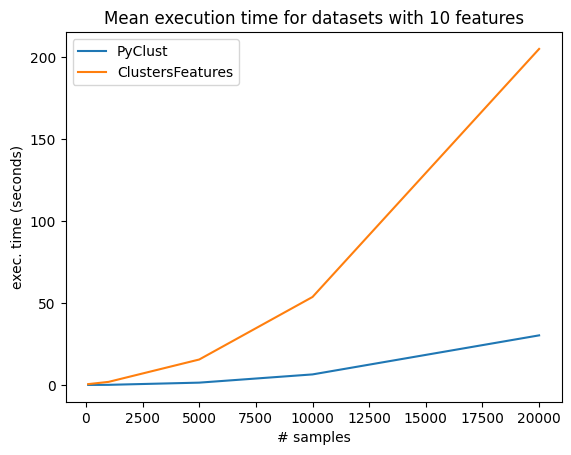

In [47]:
plt.plot([100, 1000, 5000, 10000, 20000], PC_df_mean[10], label="PyClust")
plt.plot([100, 1000, 5000, 10000, 20000], CC_df_mean[10], label="ClustersFeatures")
plt.xlabel("# samples")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 10 features")
plt.legend()
plt.show()

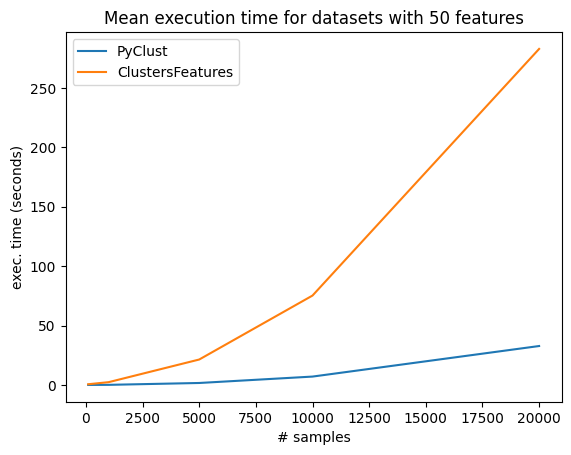

In [48]:
plt.plot([100, 1000, 5000, 10000, 20000], PC_df_mean[50], label="PyClust")
plt.plot([100, 1000, 5000, 10000, 20000], CC_df_mean[50], label="ClustersFeatures")
plt.xlabel("# samples")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 50 features")
plt.legend()
plt.show()

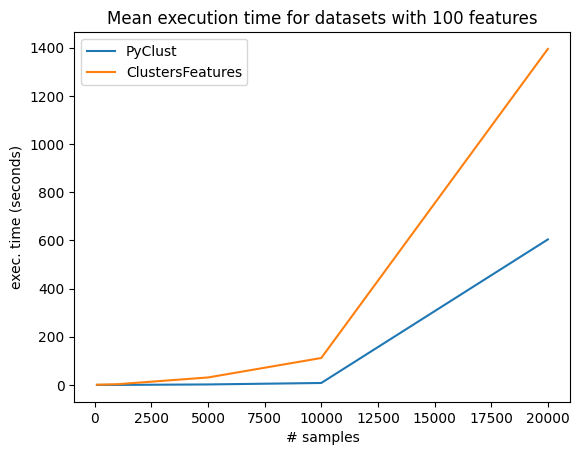

In [49]:
plt.plot([100, 1000, 5000, 10000, 20000], PC_df_mean[100], label="PyClust")
plt.plot([100, 1000, 5000, 10000, 20000], CC_df_mean[100], label="ClustersFeatures")
plt.xlabel("# samples")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 100 features")
plt.legend()
plt.show()

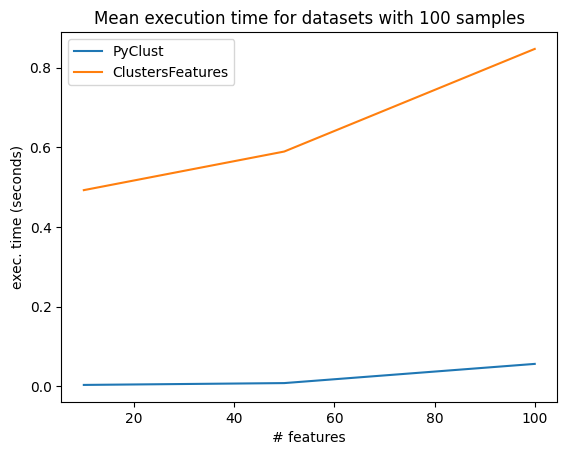

In [51]:
plt.plot([10, 50, 100], PC_df_mean.iloc[0], label="PyClust")
plt.plot([10, 50, 100], CC_df_mean.iloc[0], label="ClustersFeatures")
plt.xlabel("# features")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 100 samples")
plt.legend()
plt.show()

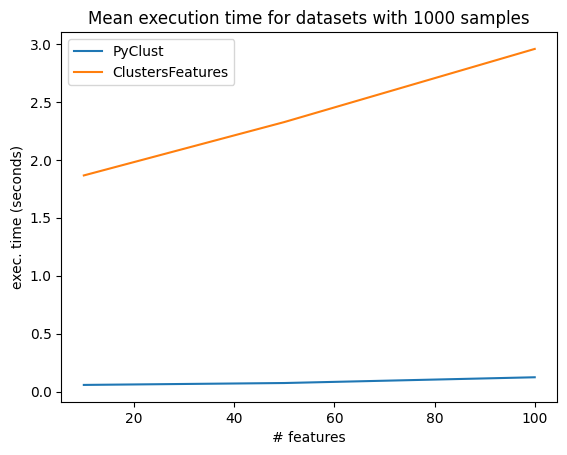

In [52]:
plt.plot([10, 50, 100], PC_df_mean.iloc[1], label="PyClust")
plt.plot([10, 50, 100], CC_df_mean.iloc[1], label="ClustersFeatures")
plt.xlabel("# features")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 1000 samples")
plt.legend()
plt.show()

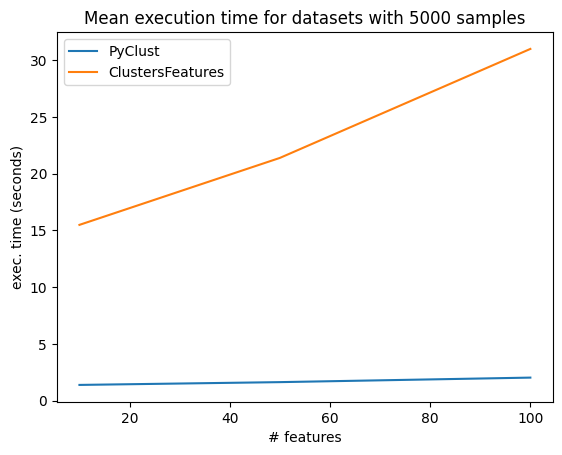

In [53]:
plt.plot([10, 50, 100], PC_df_mean.iloc[2], label="PyClust")
plt.plot([10, 50, 100], CC_df_mean.iloc[2], label="ClustersFeatures")
plt.xlabel("# features")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 5000 samples")
plt.legend()
plt.show()

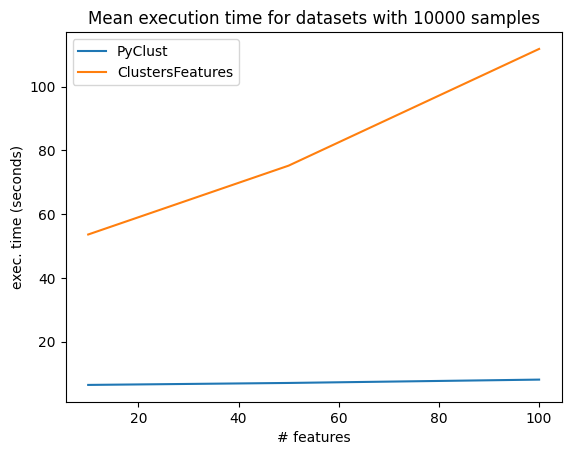

In [54]:
plt.plot([10, 50, 100], PC_df_mean.iloc[3], label="PyClust")
plt.plot([10, 50, 100], CC_df_mean.iloc[3], label="ClustersFeatures")
plt.xlabel("# features")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 10000 samples")
plt.legend()
plt.show()

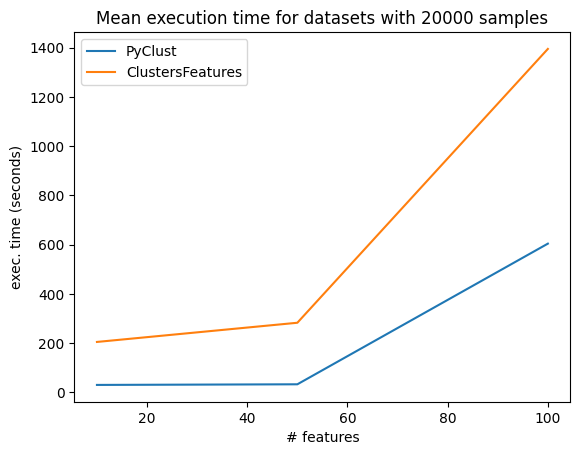

In [55]:
plt.plot([10, 50, 100], PC_df_mean.iloc[4], label="PyClust")
plt.plot([10, 50, 100], CC_df_mean.iloc[4], label="ClustersFeatures")
plt.xlabel("# features")
plt.ylabel("exec. time (seconds)")
plt.title("Mean execution time for datasets with 20000 samples")
plt.legend()
plt.show()

We see that in every case, PyClust outperforms ClustersFeatures in terms of execution time, strengthening the usefulness of the intermediate computation backtracking and the fact that PyClust is written purelly on NumPy whereas on the other hand ClustersFeatures is based on Pandas.

In [39]:
CC_df_mean.to_csv('mean_exec_time_CC.csv')
CC_df_std.to_csv('std_exec_time_CC.csv')
PC_df_mean.to_csv('mean_exec_time_PC.csv')
PC_df_std.to_csv('std_exec_time_PC.csv')

## ClusterCrit

ClusterCrit is one of the most popular modules for CVI calculation and is implemented in R. Because of that we are going to invoke another ready-to-execute R script through the following python cells. The library features 40 CVIs which which is a subset of the offered PyClust CVI and as such to ensure fair comparison we will reduce the set of CVIs called through PyClust to match ClusterCrit. 

The ClusterCrit R benchmark script is located under benchmarks/scripts.

**Warning!!!**
The following are required to run the benchmark script for ClusterCrit.
- R > 4 (tested with R == 4.5.1)
- RTools

Additionally a couple of R modules will be automatically installed to the system. 

### Benchmark Scripts

This scetion can be skipped as it contains the code to run the benchmarks. They however have already ran and the results are stored in the respective folder benchmarks/results/vsClusterCrit.

If you want to run them please be midnful of the execution times as it gets expensive as the number of samples grows.  

In [ ]:
import subprocess, sys

project_dir = r"d:\PyClust-Eval\benchmarks\scripts"

proc = subprocess.Popen(
    ["Rscript", "--vanilla", "clusterCrit.R"],
    cwd=project_dir,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,              # decode to str
    bufsize=1               # line-buffered
)

for line in proc.stdout:
    print(line, end="")     # show each line immediately
    sys.stdout.flush()      # force Jupyter to render now

returncode = proc.wait()
print("\n[process exited with]", returncode)


clusterctit_results_mean, clustercrit_results_std = open_results(foldername="vsClusterCrit", filename="clustercrit_results.json")
print(clusterctit_results_mean)
print(clustercrit_results_std)

[1] "100"
[1] 0.00792098
[1] "100"
[1] 0.01654983
[1] "100"
[1] 0.01048708
[1] "1000"
[1] 65.82838
[1] "1000"
[1] 65.83005
[1] "1000"
[1] 65.70784


In [ ]:
# Main Script to retrieve execution time for sklearn.
results = {}
for folder in os.listdir(data_path):
    if folder not in results.keys(): 
        results[folder] = {}
    for p in os.listdir(os.path.join(data, folder)):
        nsamples, nfeatures = extract_meta(p)
        if nsamples not in results[folder].keys(): 
            results[folder][nsamples] = {}
        df = pd.read_csv(os.path.join(data, folder, p))
        
        # CVI calculation
        start_time = time.time()
        cvit = CVIToolbox(df.drop(columns="target"), df["target"])
        cvit.calculate_icvi(exclude=["g_plus", "gamma", "tau", "cdbw", "ksq_detw"])
        time_taken = time.time() - start_time
        results[folder][nsamples][nfeatures] = time_taken 
    print(results)

write_results(foldername="vsClusterCrit", filename="pyclust_vs_clustercrit.json")